# LSTM
CNN_264 with LSTM.

In [47]:
from datetime import datetime
print(datetime.now())

2023-03-27 21:56:15.842645


In [48]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [49]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=8
DCELLS=8
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [50]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [51]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [52]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [53]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    rnn1_layer = LSTM(RCELLS, return_sequences=True) 
    drop1_layer = Dropout(0.5) 
    dens_layer = TimeDistributed(Dense(DCELLS))
    flat_layer = Flatten()
    drop2_layer = Dropout(0.5) 
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(drop1_layer)
    rnn.add(dens_layer)
    rnn.add(flat_layer)
    rnn.add(drop2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [54]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-27 21:56:19.170696
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 lstm_29 (LSTM)              (None, 4997, 8)           416       
                                                                 
 dropout_53 (Dropout)        (None, 4997, 8)           0         
                                                                 
 time_distributed_29 (TimeDi  (None, 4997, 8)          72        
 stributed)                                                      
                                                                 
 flatten_29 (Flatten)        (None, 39976)             0         
                                                                 
 dropout_54 (Dropout)        (None, 39976)             0         
                          

## Training

In [55]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [56]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-27 21:56:19.570553
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-27 21:56:27.361412

Training # 1 1
2023-03-27 21:56:27.362043
2023-03-27 21:56:27.362094
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-27 21:56:28.854582


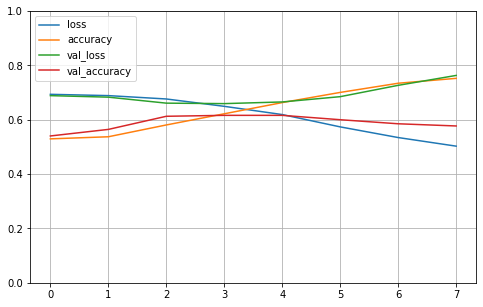


2023-03-27 21:58:53.006650

Testing # 1 1
2023-03-27 21:58:53.006743
2023-03-27 21:58:53.006789
PREDICT
2023-03-27 21:58:53.215005
Test 1:0 458:412 52.64%
Predict 1:0 348:522 40.00%
Test sizes (870, 4997) (870,)
Range of scores: 0.006568629 to 0.98840964
Score threshold 0.5
Confusion matrix
 [[283 129]
 [239 219]]
Normalized matrix
 [[0.32528736 0.14827586]
 [0.27471264 0.25172414]]


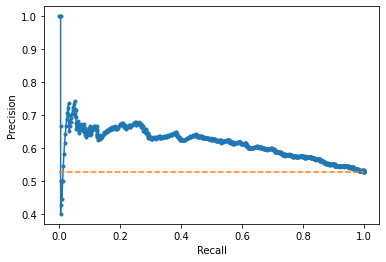

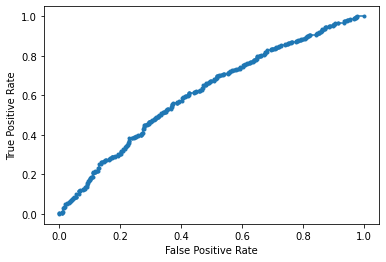

Accuracy: 57.70% Precision: 62.93% Recall: 47.82%
F1: 54.34% MCC: 0.1682
AUPRC: 61.57% AUROC: 61.40%
 accuracy [57.701149425287355]
 precision [62.93103448275862]
 recall [47.81659388646288]
 F1 [54.3424317617866]
 MCC [0.1682271388939793]
 AUPRC [61.57106862892848]
 AUROC [61.40352736676983]
2023-03-27 21:58:55.195241

Training # 1 2
2023-03-27 21:58:55.195894
2023-03-27 21:58:55.195940
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-27 21:58:57.252019


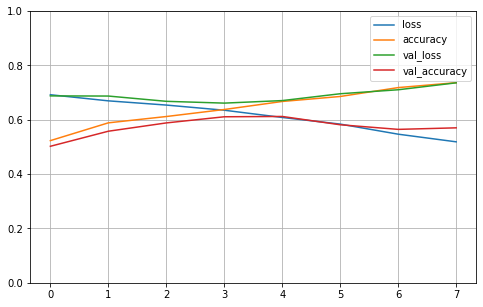


2023-03-27 22:01:22.562317

Testing # 1 2
2023-03-27 22:01:22.562417
2023-03-27 22:01:22.562455
PREDICT
2023-03-27 22:01:22.783450
Test 1:0 442:442 50.00%
Predict 1:0 506:378 57.24%
Test sizes (884, 4997) (884,)
Range of scores: 0.0022873734 to 0.99015135
Score threshold 0.5
Confusion matrix
 [[220 222]
 [158 284]]
Normalized matrix
 [[0.24886878 0.25113122]
 [0.17873303 0.32126697]]


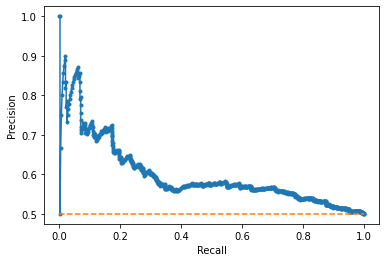

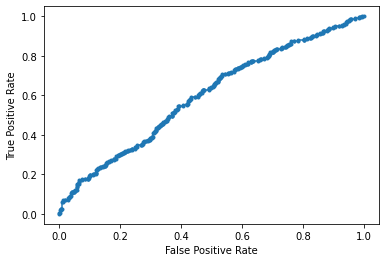

Accuracy: 57.01% Precision: 56.13% Recall: 64.25%
F1: 59.92% MCC: 0.1418
AUPRC: 59.88% AUROC: 59.92%
 accuracy [57.01357466063348]
 precision [56.126482213438734]
 recall [64.25339366515837]
 F1 [59.91561181434599]
 MCC [0.14176549255747525]
 AUPRC [59.882025862727126]
 AUROC [59.91789684895886]
2023-03-27 22:01:24.790171

Training # 1 3
2023-03-27 22:01:24.790831
2023-03-27 22:01:24.790874
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-27 22:01:26.151146


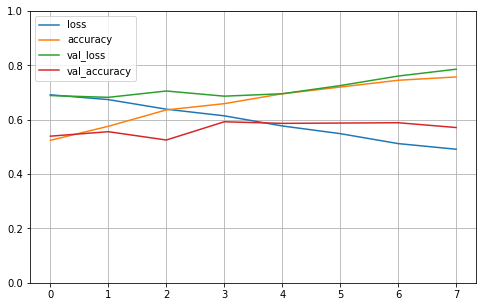


2023-03-27 22:03:50.156662

Testing # 1 3
2023-03-27 22:03:50.158047
2023-03-27 22:03:50.158376
PREDICT
2023-03-27 22:03:50.555202
Test 1:0 442:407 52.06%
Predict 1:0 460:389 54.18%
Test sizes (849, 4997) (849,)
Range of scores: 0.003332541 to 0.9894121
Score threshold 0.5
Confusion matrix
 [[216 191]
 [173 269]]
Normalized matrix
 [[0.25441696 0.22497055]
 [0.20376914 0.31684335]]


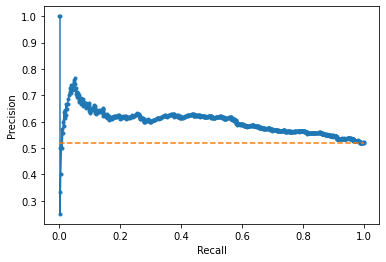

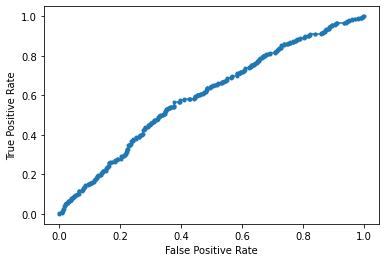

Accuracy: 57.13% Precision: 58.48% Recall: 60.86%
F1: 59.65% MCC: 0.1397
AUPRC: 59.95% AUROC: 60.04%
 accuracy [57.126030624263834]
 precision [58.47826086956521]
 recall [60.85972850678733]
 F1 [59.64523281596451]
 MCC [0.13968068002865938]
 AUPRC [59.948835765575645]
 AUROC [60.04035709918063]
2023-03-27 22:03:53.116214

Training # 1 4
2023-03-27 22:03:53.116724
2023-03-27 22:03:53.116781
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-27 22:03:54.466657


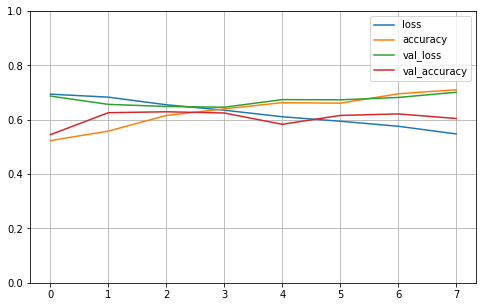


2023-03-27 22:05:27.492011

Testing # 1 4
2023-03-27 22:05:27.492101
2023-03-27 22:05:27.492135
PREDICT
2023-03-27 22:05:27.712634
Test 1:0 459:431 51.57%
Predict 1:0 375:515 42.13%
Test sizes (890, 4997) (890,)
Range of scores: 0.008014845 to 0.9543325
Score threshold 0.5
Confusion matrix
 [[297 134]
 [218 241]]
Normalized matrix
 [[0.33370787 0.1505618 ]
 [0.24494382 0.27078652]]


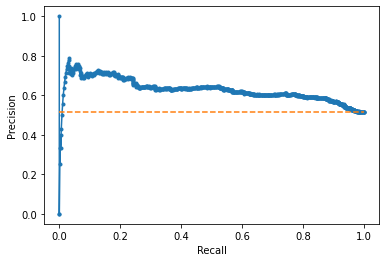

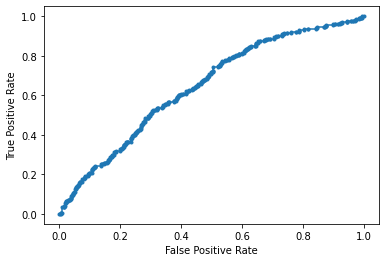

Accuracy: 60.45% Precision: 64.27% Recall: 52.51%
F1: 57.79% MCC: 0.2167
AUPRC: 62.84% AUROC: 64.56%
 accuracy [60.449438202247194]
 precision [64.26666666666667]
 recall [52.505446623093675]
 F1 [57.793764988009585]
 MCC [0.2167419540760986]
 AUPRC [62.83928518336821]
 AUROC [64.56131305319242]
2023-03-27 22:05:29.708944

Training # 1 5
2023-03-27 22:05:29.709548
2023-03-27 22:05:29.709590
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-27 22:05:31.808179


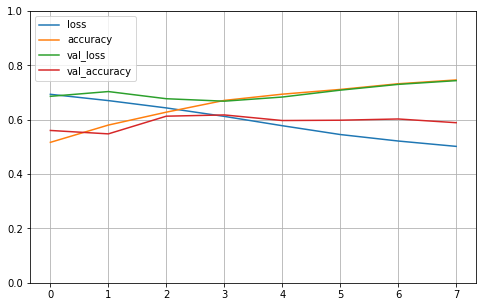


2023-03-27 22:07:56.179358

Testing # 1 5
2023-03-27 22:07:56.181059
2023-03-27 22:07:56.181424
PREDICT
2023-03-27 22:07:56.590412
Test 1:0 457:419 52.17%
Predict 1:0 557:319 63.58%
Test sizes (876, 4997) (876,)
Range of scores: 0.005283095 to 0.99761105
Score threshold 0.5
Confusion matrix
 [[189 230]
 [130 327]]
Normalized matrix
 [[0.21575342 0.26255708]
 [0.14840183 0.37328767]]


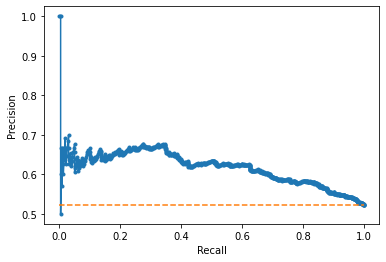

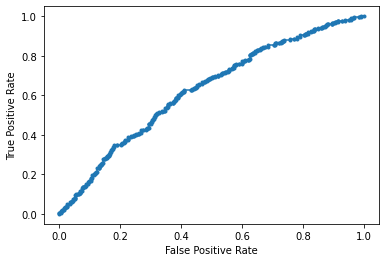

Accuracy: 58.90% Precision: 58.71% Recall: 71.55%
F1: 64.50% MCC: 0.1730
AUPRC: 61.85% AUROC: 62.81%
 accuracy [58.9041095890411]
 precision [58.707360861759426]
 recall [71.55361050328227]
 F1 [64.49704142011835]
 MCC [0.17295912250094944]
 AUPRC [61.846060464978066]
 AUROC [62.8113200649666]
2023-03-27 22:07:59.290994

Training # 2 1
2023-03-27 22:07:59.291614
2023-03-27 22:07:59.291658
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-27 22:08:00.639333


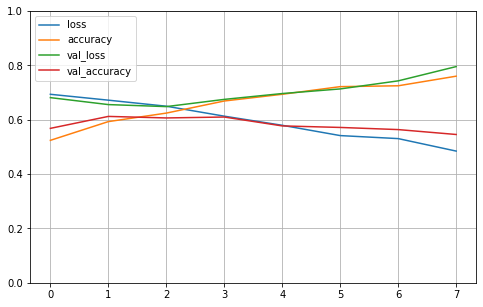


2023-03-27 22:09:35.615298

Testing # 2 1
2023-03-27 22:09:35.615406
2023-03-27 22:09:35.615443
PREDICT
2023-03-27 22:09:35.831640
Test 1:0 472:415 53.21%
Predict 1:0 419:468 47.24%
Test sizes (887, 4997) (887,)
Range of scores: 0.0012013699 to 0.99922395
Score threshold 0.5
Confusion matrix
 [[240 175]
 [228 244]]
Normalized matrix
 [[0.27057497 0.19729425]
 [0.25704622 0.27508455]]


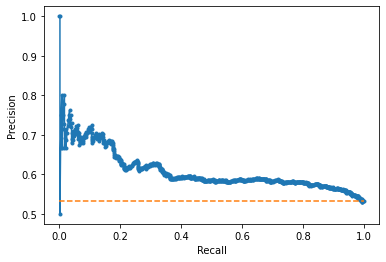

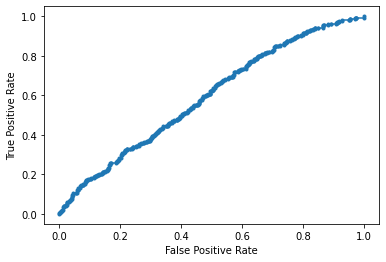

Accuracy: 54.57% Precision: 58.23% Recall: 51.69%
F1: 54.77% MCC: 0.0952
AUPRC: 60.86% AUROC: 59.21%
 accuracy [54.56595264937994]
 precision [58.233890214797135]
 recall [51.69491525423729]
 F1 [54.7699214365881]
 MCC [0.09521089633570932]
 AUPRC [60.85806057275243]
 AUROC [59.21380437002246]
2023-03-27 22:09:37.856955

Training # 2 2
2023-03-27 22:09:37.857526
2023-03-27 22:09:37.857573
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-27 22:09:39.203961


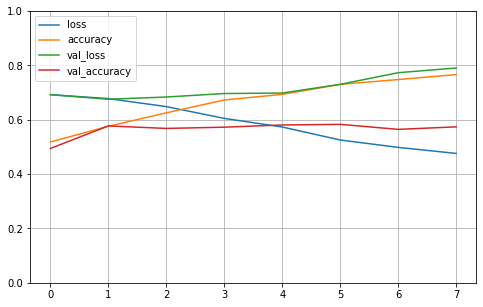


2023-03-27 22:12:04.252312

Testing # 2 2
2023-03-27 22:12:04.253939
2023-03-27 22:12:04.254277
PREDICT
2023-03-27 22:12:04.654926
Test 1:0 452:416 52.07%
Predict 1:0 554:314 63.82%
Test sizes (868, 4997) (868,)
Range of scores: 0.0060431473 to 0.99470806
Score threshold 0.5
Confusion matrix
 [[180 236]
 [134 318]]
Normalized matrix
 [[0.20737327 0.2718894 ]
 [0.15437788 0.36635945]]


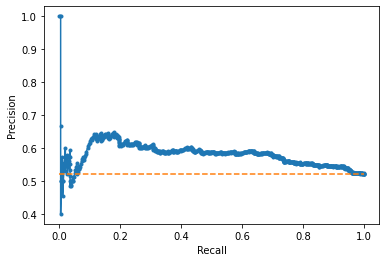

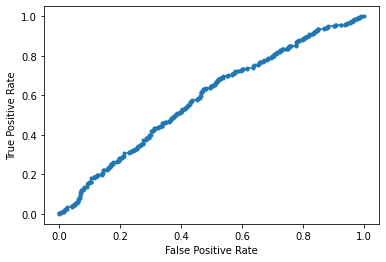

Accuracy: 57.37% Precision: 57.40% Recall: 70.35%
F1: 63.22% MCC: 0.1416
AUPRC: 58.09% AUROC: 58.67%
 accuracy [57.373271889400925]
 precision [57.400722021660656]
 recall [70.35398230088495]
 F1 [63.220675944334005]
 MCC [0.1416366758332509]
 AUPRC [58.094228928595705]
 AUROC [58.67458730428863]
2023-03-27 22:12:07.356262

Training # 2 3
2023-03-27 22:12:07.356410
2023-03-27 22:12:07.356455
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-27 22:12:08.736018


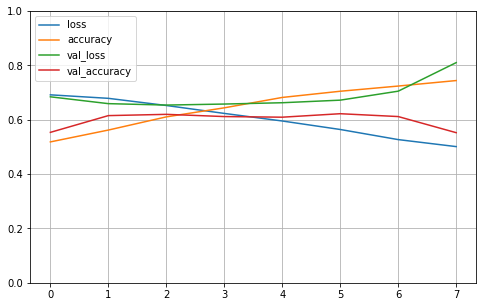


2023-03-27 22:14:32.919872

Testing # 2 3
2023-03-27 22:14:32.920255
2023-03-27 22:14:32.920291
PREDICT
2023-03-27 22:14:33.136712
Test 1:0 453:407 52.67%
Predict 1:0 236:624 27.44%
Test sizes (860, 4997) (860,)
Range of scores: 0.007671082 to 0.96844393
Score threshold 0.5
Confusion matrix
 [[323  84]
 [301 152]]
Normalized matrix
 [[0.3755814  0.09767442]
 [0.35       0.17674419]]


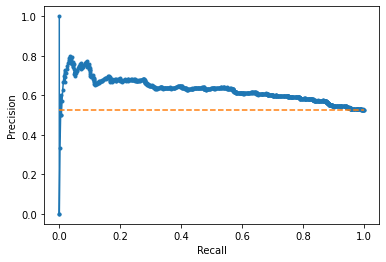

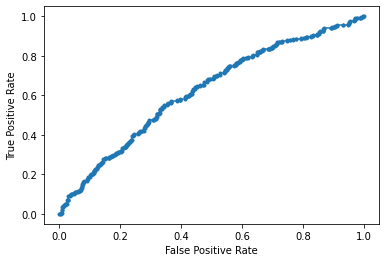

Accuracy: 55.23% Precision: 64.41% Recall: 33.55%
F1: 44.12% MCC: 0.1445
AUPRC: 62.78% AUROC: 62.39%
 accuracy [55.23255813953488]
 precision [64.40677966101694]
 recall [33.554083885209714]
 F1 [44.121915820029024]
 MCC [0.14451112165988103]
 AUPRC [62.77802251023037]
 AUROC [62.386709406576955]
2023-03-27 22:14:35.162701

Training # 2 4
2023-03-27 22:14:35.163510
2023-03-27 22:14:35.163556
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-27 22:14:36.523559


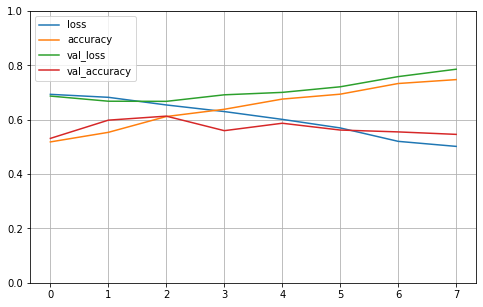


2023-03-27 22:17:01.090247

Testing # 2 4
2023-03-27 22:17:01.091634
2023-03-27 22:17:01.091977
PREDICT
2023-03-27 22:17:01.509775
Test 1:0 432:447 49.15%
Predict 1:0 503:376 57.22%
Test sizes (879, 4997) (879,)
Range of scores: 0.017978901 to 0.9945156
Score threshold 0.5
Confusion matrix
 [[212 235]
 [164 268]]
Normalized matrix
 [[0.24118316 0.26734926]
 [0.18657565 0.30489192]]


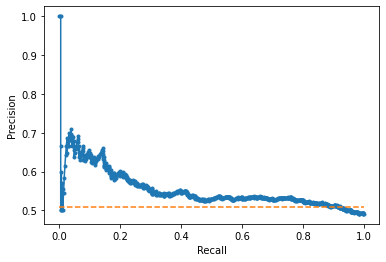

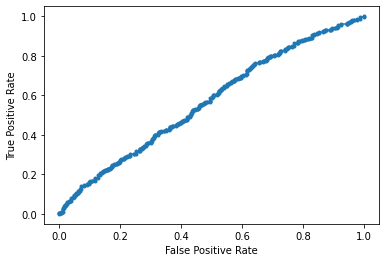

Accuracy: 54.61% Precision: 53.28% Recall: 62.04%
F1: 57.33% MCC: 0.0956
AUPRC: 55.37% AUROC: 56.89%
 accuracy [54.60750853242321]
 precision [53.28031809145129]
 recall [62.03703703703704]
 F1 [57.32620320855615]
 MCC [0.09563296028491797]
 AUPRC [55.372391252874166]
 AUROC [56.89421244510731]
2023-03-27 22:17:04.963540

Training # 2 5
2023-03-27 22:17:04.963728
2023-03-27 22:17:04.963787
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-27 22:17:06.314991


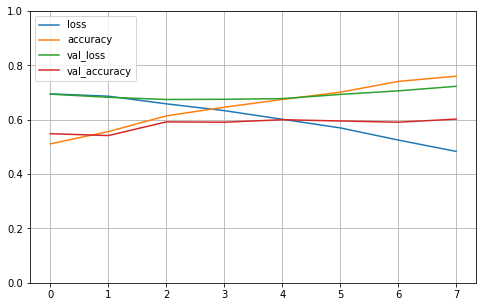


2023-03-27 22:18:42.013039

Testing # 2 5
2023-03-27 22:18:42.013338
2023-03-27 22:18:42.013385
PREDICT
2023-03-27 22:18:42.234266
Test 1:0 449:426 51.31%
Predict 1:0 485:390 55.43%
Test sizes (875, 4997) (875,)
Range of scores: 0.0060745617 to 0.97795975
Score threshold 0.5
Confusion matrix
 [[234 192]
 [156 293]]
Normalized matrix
 [[0.26742857 0.21942857]
 [0.17828571 0.33485714]]


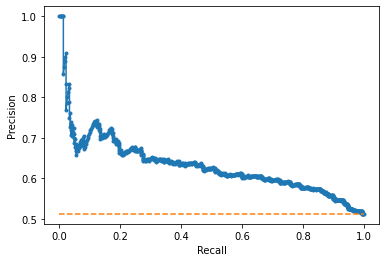

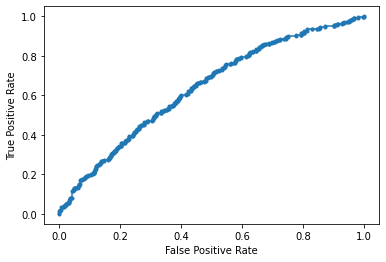

Accuracy: 60.23% Precision: 60.41% Recall: 65.26%
F1: 62.74% MCC: 0.2030
AUPRC: 63.19% AUROC: 63.64%
 accuracy [60.22857142857143]
 precision [60.41237113402062]
 recall [65.25612472160356]
 F1 [62.74089935760171]
 MCC [0.20298720270732612]
 AUPRC [63.1903703825748]
 AUROC [63.63959555402198]
2023-03-27 22:18:44.217964


In [57]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [58]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 57.32% std 2.12
 precision mean 59.42% std 3.61
 recall mean 57.99% std 11.66
 F1 mean 57.84% std 5.92
 MCC mean 0.15% std 0.04
 AUPRC mean 60.64% std 2.44
 AUROC mean 60.95% std 2.42
 accuracy [[57.701149425287355], [57.01357466063348], [57.126030624263834], [60.449438202247194], [58.9041095890411], [54.56595264937994], [57.373271889400925], [55.23255813953488], [54.60750853242321], [60.22857142857143]]
 precision [[62.93103448275862], [56.126482213438734], [58.47826086956521], [64.26666666666667], [58.707360861759426], [58.233890214797135], [57.400722021660656], [64.40677966101694], [53.28031809145129], [60.41237113402062]]
 recall [[47.81659388646288], [64.25339366515837], [60.85972850678733], [52.505446623093675], [71.55361050328227], [51.69491525423729], [70.35398230088495], [33.554083885209714], [62.03703703703704], [65.25612472160356]]
 F1 [[54.3424317617866], [59.91561181434599], [59.64523281596451], [57.793764988009585], [64.49704142011835], [54.7699214365881], 